In [66]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from preprocess import (
    load_tdms_first_channel, PreParams, prefilter_pipeline, time_axis,
    equi_ripple_highpass_fir, equi_ripple_lowpass_fir, fir_freq_response,
    detect_r_peaks, PeakParams, qc_metrics
)

TDMS_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"  # <-- SÆT DENNE
FS_OVERRIDE = None  # fx 512.0 hvis wf_increment mangler

P = PreParams(
    drop_start_s = 300.0,
    drop_end_s = 300.0,
    target_fs = 512.0,  # resample hvis ønsket
    hp_pass_hz = 30.0,  # baseline
    hp_stop_hz = 1.0,
    lp_pass_hz = 32.0,  # QRS-fokus
    lp_stop_hz = 50.0
)
plt.rcParams["figure.figsize"] = (14, 4)


path -> Load -> data

Secound to be deleted in begining of signal og secounds of end of signal deleted uses samplerate.

Highpass Equi -> Lowpass Equi -> Smoothing.

In [67]:
out = load_tdms_first_channel(TDMS_PATH)
x = out["signal"]
fs = out["fs"]
t0 = out["start_time"]

print(f"Signal: {len(x)} samples, fs={fs:.2f} Hz, starttid={t0}")



Signal: 82460288 samples, fs=512.00 Hz, starttid=2016-10-12T09:05:02.000000


In [68]:
stages = prefilter_pipeline(x, fs, P)

In [69]:
print(stages.keys())
x_smooth = stages["smoothed"]

dict_keys(['raw', 'trim', 'resampled', 'highpass', 'lowpass', 'smoothed', '_fs', '_bhp', '_blp'])


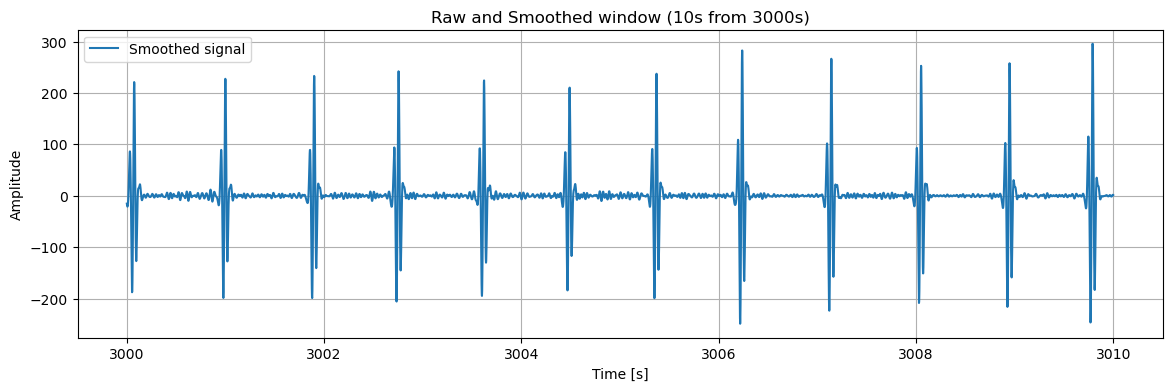

In [74]:
sec = 10        # window size in seconds
start_s = 3000     # start time in seconds

i0 = int(start_s * fs)
i1 = i0 + int(sec * fs)

plt.figure(figsize=(14, 4))
# plt.plot(t[i0:i1], x[i0:i1], label="Raw signal")
plt.plot(t[i0:i1], x_smooth[i0:i1], label="Smoothed signal")
plt.title(f"Raw and Smoothed window ({sec}s from {start_s}s)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [3]:
from scipy.signal import filtfilt

# Remove start and end seconds from raw signal using samplerate
drop_start = int(P.drop_start_s * fs)
drop_end = int(P.drop_end_s * fs)
x_raw = x[drop_start:len(x)-drop_end]
fs_raw = fs

# Design equi-ripple FIR filters
# bhp = equi_ripple_highpass_fir(fs, P.hp_pass_hz, P.hp_stop_hz)
# blp = equi_ripple_lowpass_fir(fs, P.lp_pass_hz, P.lp_stop_hz)

# 512 Hz, high-pass Equiripple filter
b_hp = equi_ripple_highpass_fir(fs, P.hp_pass_hz, P.hp_stop_hz)
b_lp = equi_ripple_lowpass_fir(fs, P.lp_pass_hz, P.lp_stop_hz)

# Apply highpass then lowpass
x_hp = filtfilt(b_hp, [1.0], x_raw)
x_lp = filtfilt(b_lp, [1.0], x_hp)

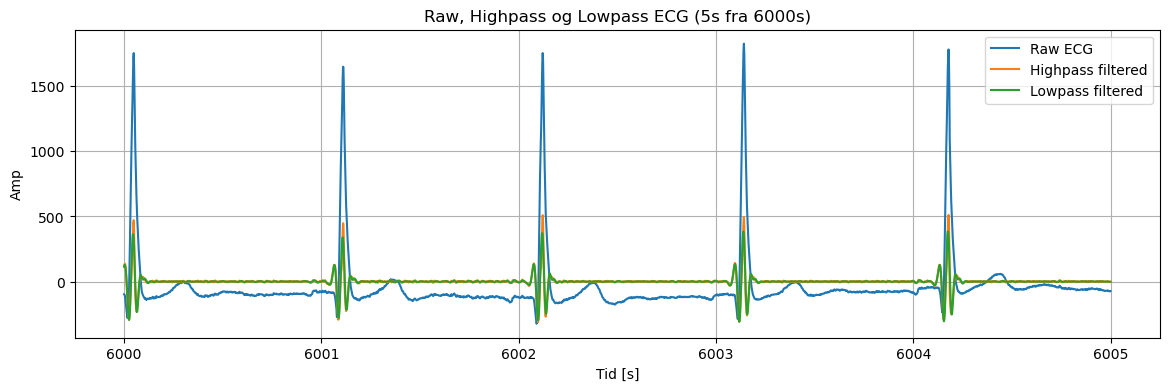

In [6]:
sec = 5
start_s = 6000
i0 = int(start_s * fs)
i1 = i0 + int(sec * fs)
t = np.arange(len(x_raw)) / fs

fig, ax = plt.subplots()
ax.plot(t[i0:i1], x_raw[i0:i1], label="Raw ECG")
ax.plot(t[i0:i1], x_hp[i0:i1], label="Highpass filtered")
ax.plot(t[i0:i1], x_lp[i0:i1], label="Lowpass filtered")
ax.set_title(f"Raw, Highpass og Lowpass ECG ({sec}s fra {start_s}s)")
ax.set_xlabel("Tid [s]")
ax.set_ylabel("Amp")
ax.grid(True)
ax.legend()
plt.show()


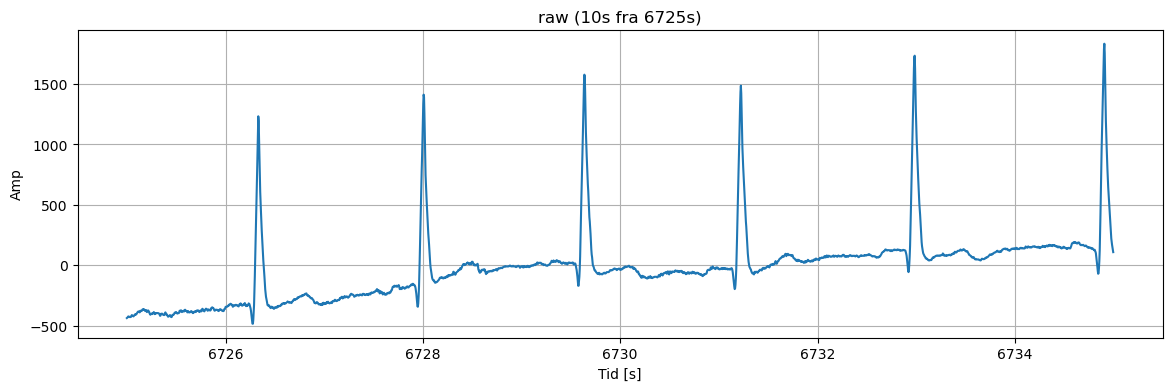

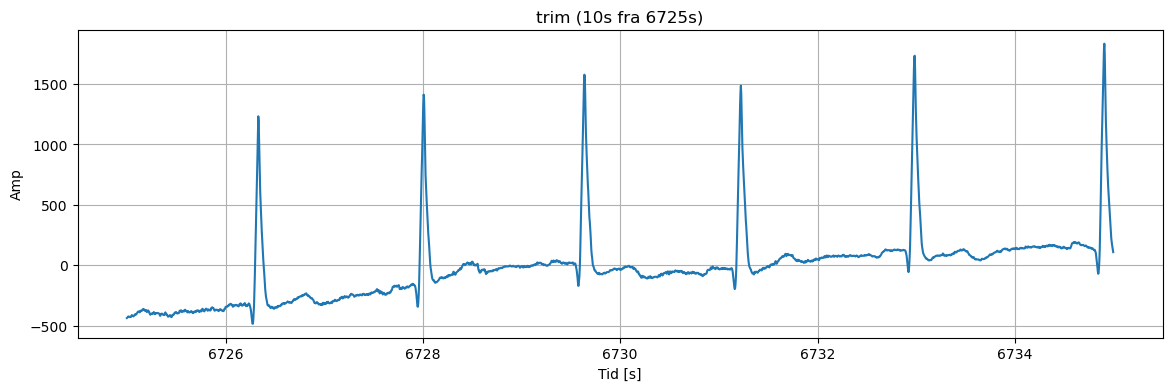

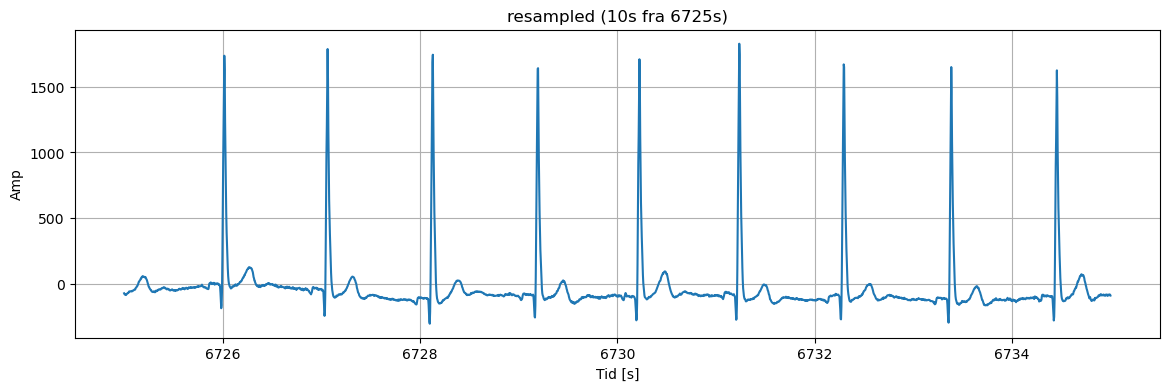

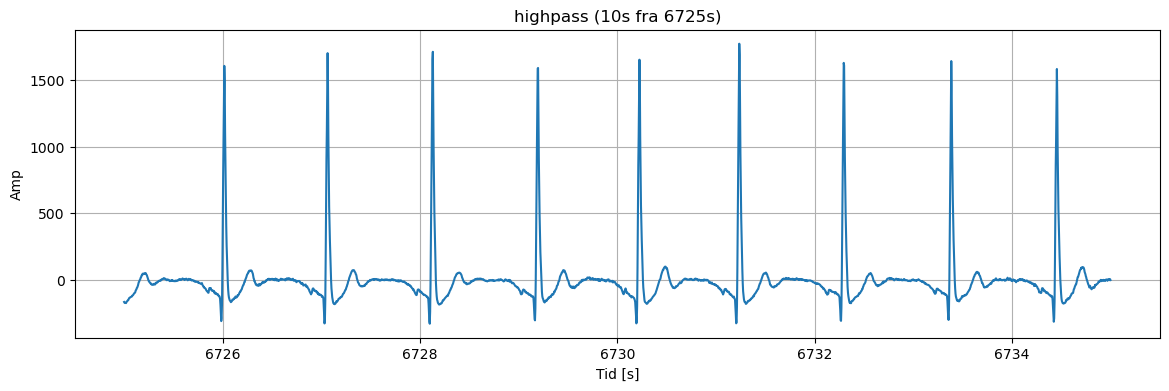

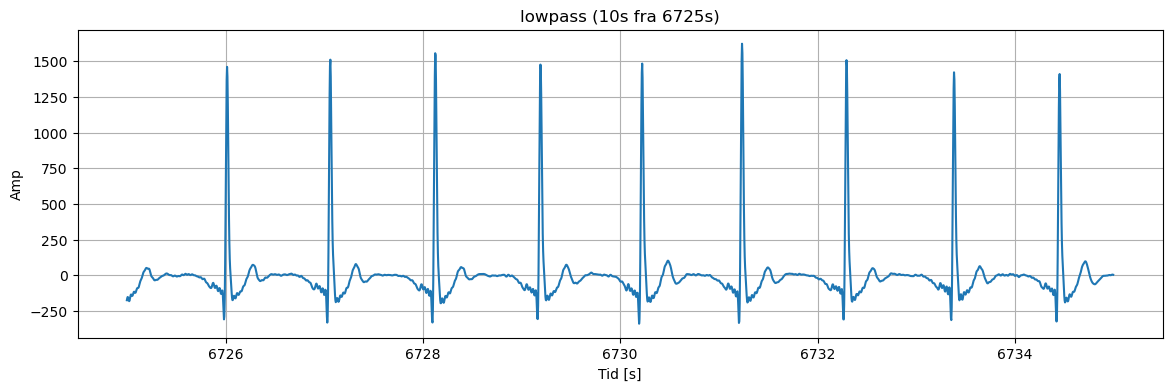

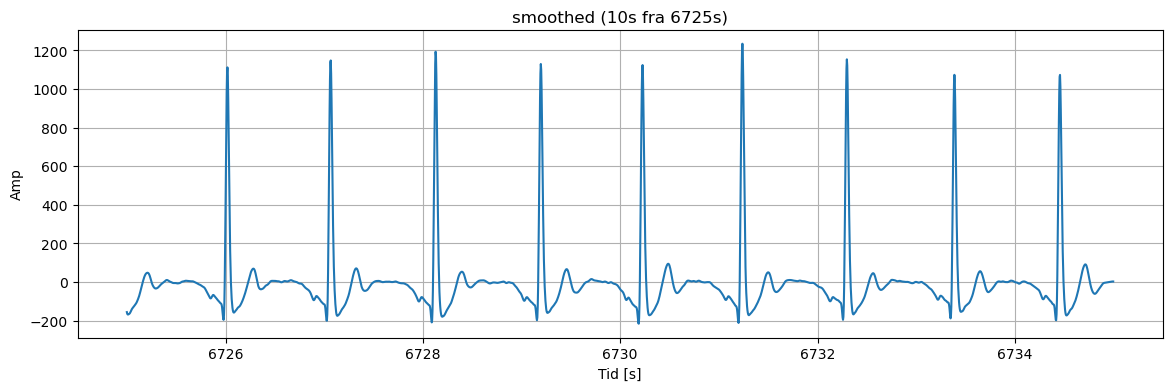

In [8]:
stages = prefilter_pipeline(x_raw, fs_raw, P)
fs = float(stages["_fs"][0])

def plot_stage(name, sec=10, start_s=0):
    x = stages[name]; t = time_axis(x, fs)
    i0 = int(start_s*fs); i1 = i0 + int(sec*fs)
    fig, ax = plt.subplots()
    ax.plot(t[i0:i1], x[i0:i1]); ax.grid(True)
    ax.set_title(f"{name} ({sec}s fra {start_s}s)")
    ax.set_xlabel("Tid [s]"); ax.set_ylabel("Amp")
    plt.show()

for nm in ["raw","trim","resampled","highpass","lowpass","smoothed"]:
    if nm in stages: plot_stage(nm, sec=10, start_s=6725)


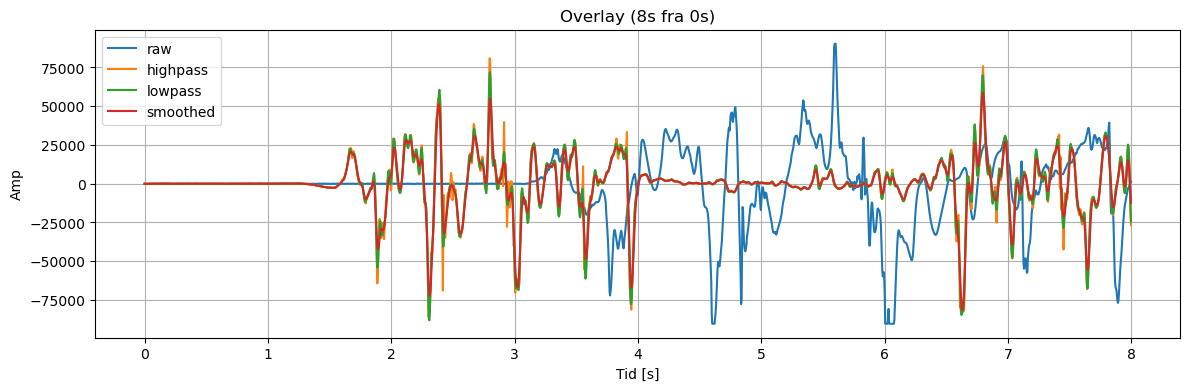

In [13]:
def overlay(sec=8, start_s=0, names=("raw","highpass","lowpass","smoothed")):
    fig, ax = plt.subplots()
    for nm in names:
        x = stages[nm]; t = time_axis(x, fs)
        i0 = int(start_s*fs); i1 = i0 + int(sec*fs)
        ax.plot(t[i0:i1], x[i0:i1], label=nm)
    ax.set_title(f"Overlay ({sec}s fra {start_s}s)")
    ax.set_xlabel("Tid [s]"); ax.set_ylabel("Amp"); ax.grid(True); ax.legend()
    plt.show()

overlay(sec=8, start_s=0)


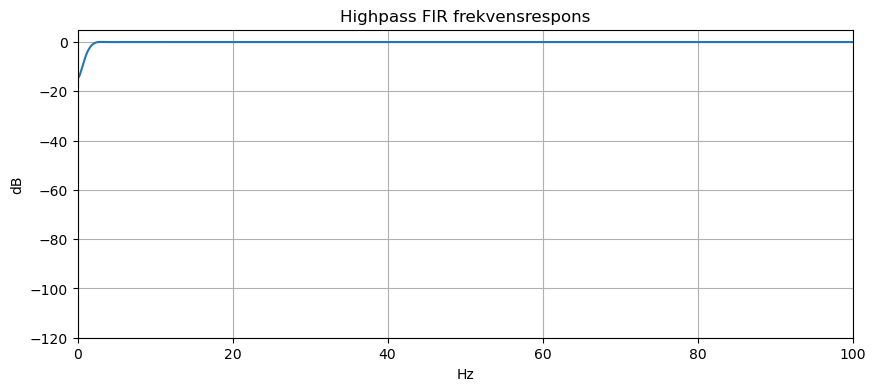

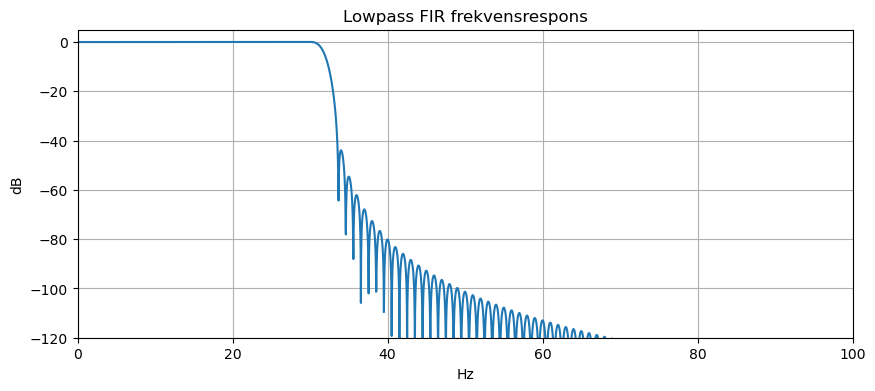

In [14]:
bhp = stages["_bhp"]; blp = stages["_blp"]
for name, b in [("Highpass", bhp), ("Lowpass", blp)]:
    f, db = fir_freq_response(b, fs=fs)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(f, db); ax.set_xlim(0, 100); ax.set_ylim(-120, 5)
    ax.set_title(f"{name} FIR frekvensrespons"); ax.set_xlabel("Hz"); ax.set_ylabel("dB")
    ax.grid(True); plt.show()


Detekterede 169975 R-toppe


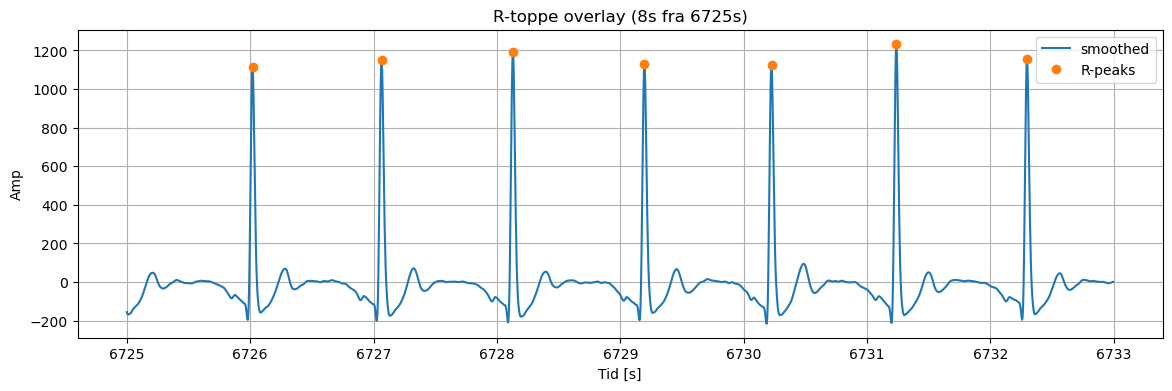

In [16]:
x_for_peaks = stages["smoothed"]
peaks = detect_r_peaks(x_for_peaks, fs, PeakParams(min_rr_s=0.25, prominence=0.8, height_std=0))
print(f"Detekterede {len(peaks)} R-toppe")

sec = 8; start_s = 6725
i0 = int(start_s*fs); i1 = i0 + int(sec*fs); t = time_axis(x_for_peaks, fs)
fig, ax = plt.subplots()
ax.plot(t[i0:i1], x_for_peaks[i0:i1], label="smoothed")
mask = (peaks>=i0) & (peaks<i1)
ax.plot(t[peaks[mask]], x_for_peaks[peaks[mask]], "o", ms=6, label="R-peaks")
ax.set_title(f"R-toppe overlay ({sec}s fra {start_s}s)")
ax.set_xlabel("Tid [s]"); ax.set_ylabel("Amp"); ax.grid(True); ax.legend(); plt.show()


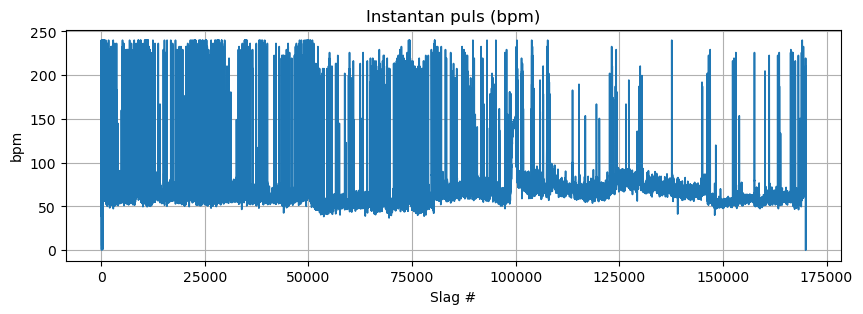

RR median: 0.949s | HR median: 63.2 bpm


In [17]:
if len(peaks) > 1:
    rr = np.diff(peaks) / fs
    hr = 60.0 / rr
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(hr, linewidth=1.2); ax.set_title("Instantan puls (bpm)")
    ax.set_xlabel("Slag #"); ax.set_ylabel("bpm"); ax.grid(True); plt.show()
    print(f"RR median: {np.median(rr):.3f}s | HR median: {np.median(hr):.1f} bpm")
else:
    print("For få peaks til HRV.")


In [18]:
qc = qc_metrics(stages["raw"], stages["smoothed"])
for k,v in qc.items():
    print(f"{k:>12}: {v:.6g}")


     raw_rms: 669.874
     raw_std: 669.872
raw_flat_pct: 28.0809
    proc_rms: 373.433
    proc_std: 373.433
proc_flat_pct: 0.0130608


In [26]:
import pandas as pd

def load_lvm_rr(path_lvm: str) -> pd.DataFrame:
    """
    Indlæs LVM-fil med RR-intervaller.
    Returnerer en DataFrame med kolonner: 'Time' (s), 'RR' (s).
    Gemmer også Time-header fra linje 11.
    """
    # Læs Time-header fra linje 11
    with open(path_lvm, encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i == 10:  # line 11 (0-based index)
                time_header = line.strip()
                break

    # Læs data fra linje 24 og frem
    df = pd.read_csv(path_lvm, sep="\t", comment="#", skiprows=23, header=None)
    df.columns = ["Time", "RR"]
    return df, time_header

rr_labview, time_header = load_lvm_rr(r"D:\Speciale\Log\LabView\R-Peaks Patient5.lvm")
print("Time header from LVM:", time_header)
print(rr_labview.head())

Time header from LVM: Time	11:06:21,2650366368089258629
       Time        RR
0  1,000000  1,624412
1  2,000000  1,073804
2  3,000000  0,265930
3  4,000000  2,175366
4  5,000000  0,513129


In [23]:
rr_py = np.diff(peaks) / fs
t_peaks = peaks / fs  # peak tider i sek
t_rr_py = (t_peaks[1:] + t_peaks[:-1]) / 2  # midtpunkt for hvert RR

rr_python = pd.DataFrame({"Time": t_rr_py, "RR": rr_py})

In [21]:
import matplotlib.pyplot as plt

def compare_rr(rr_labview, rr_python, max_offset=5.0, step=0.5):
    offsets = np.arange(-max_offset, max_offset+step, step)
    for off in offsets:
        plt.figure(figsize=(10,4))
        plt.plot(rr_labview["Time"], rr_labview["RR"], label="LabVIEW")
        plt.plot(rr_python["Time"]+off, rr_python["RR"], label=f"Python + {off:.1f}s")
        plt.title(f"Sammenligning med offset {off:.1f} sek")
        plt.xlabel("Tid [s]"); plt.ylabel("RR [s]"); plt.legend(); plt.grid(True)
        plt.show()


In [25]:
# compare_rr(rr_labview, rr_python, max_offset=5, step=1)